In [1]:
import jax
from jax import numpy as np, random
import pennylane as qml
import optax

jax.config.update("jax_platform_name", "cpu")

In [11]:
key = random.key(42)
key, opt_variables_key = random.split(key,2)

shape = qml.BasicEntanglerLayers.shape(n_layers=3, n_wires=5)
opt_variables = random.normal(opt_variables_key, shape=shape)
n_wires = opt_variables.shape[1]

In [12]:
# Define quantum circuit

dev = qml.device("lightning.qubit", wires=range(n_wires))

def chebyshev_feature_map(x, wires = range(n_wires)):
    for i in wires:
        qml.RY(2*np.arccos(x),i)
        
@qml.qnode(dev, diff_method="best")
def quantum_circuit(x, opt_variables, wires=range(n_wires)):
    # Set feature map
    chebyshev_feature_map(x)

    # Set variational ansatz
    qml.BasicEntanglerLayers(weights=opt_variables, wires=range(n_wires))

    # Return value, total magnetization in Z-direction
    return [qml.expval(qml.PauliZ(i)) for i in range(n_wires)]

def cost_function(x, opt_variables):
    return sum(quantum_circuit(x ,opt_variables, wires=range(n_wires)))

def loss_boundary(x, opt_variables):
    u_0 = 1
    f_0 = cost_function(x,opt_variables)
    return optax.squared_error(f_0, u_0* np.ones_like(f_0)).mean()

# for the ODE df/dx=4x^3+x^2-2x-1/2 with f(0)=1
def loss_pde(x, opt_variables):
    df_dx = jax.grad(cost_function, argnums=0)
    grad_vec = np.array([df_dx(i, opt_variables) for i in x])

    res = grad_vec - 4*pow(x,3) - pow(x,2)  + 2*x +0.5 
    return optax.squared_error(res, np.zeros_like(res)).mean()

def loss_function(opt_variables):
    input_de = np.linspace(0.01,0.99,20)
    
    boundary_loss_scaling = 20.0
    value_boundary_loss = loss_boundary(np.zeros_like(input_de), opt_variables)
    value_pde_loss = loss_pde(input_de, opt_variables)

    return value_pde_loss + boundary_loss_scaling*value_boundary_loss

def analytical_solution(x):
    return x**4 + (1 / 3) * x**3 - x**2 - (1 / 2) * x + 1

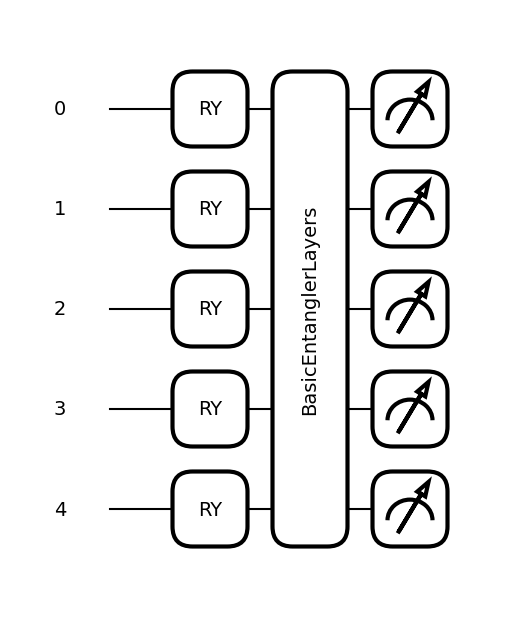

In [13]:
fig, ax = qml.draw_mpl(quantum_circuit)(1.0, opt_variables)

In [14]:
# Define Optimizer
max_iterations = 2
cov_tol = 1e-06

# @jax.jit
def optimize_jit(opt_variables):
    
    opt = optax.adam(learning_rate=0.01)
    opt_state = opt.init(opt_variables)
    loss = [loss_function(opt_variables)]

    opt_variables_history = []
    loss_history = []

    for i in range(max_iterations):
        gradient = jax.grad(loss_function, argnums=0)(opt_variables)
        updates, opt_state = opt.update(gradient, opt_state)
        opt_variables = optax.apply_updates(opt_variables, updates)

        opt_variables_history.append(opt_variables)
        loss_history.append(loss_function(opt_variables))

        if i%1 == 0:
            jax.debug.print("Step: {i}  Loss: {loss_val}", i=i, loss_val=loss_history[-1])
            #print(f"State:\t {opt_variables} \n")
            
    return [opt_variables, loss_history, opt_variables_history]

opt_variables, loss_history, opt_variables_history = optimize_jit(opt_variables)
print(10)

Step: 0  Loss: 10.519161224365234
Step: 1  Loss: 9.386882781982422


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = np.linspace(0,1,10)
f_qc = cost_function(x, opt_variables[0])
f_an = analytical_solution(x)
ax2.plot( x, f_qc, "ro", ls="dashed")
ax2.plot( x, f_an, "go", ls="dashed")
ax2.legend(["QCML", "Analytical"])